# Correlation Analysis

Use this notebook to determine if there is any correlation between our metrics and people counts at the checkpoints. 

This isn't a final analysis but may highlight some key metrics to focus on. 

There should be a correlation done for each of the checkpoints.

In [ ]:
#pyspark packages
from pyspark.sql.types import *
from pyspark.sql.functions import *

#python packages
import pandas as pd
import numpy as np
from datetime import datetime, date
from functools import reduce

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
dbutils.widgets.text('begin_date', '2022-02-01')
dbutils.widgets.text('end_date', '2022-03-01')
dbutils.widgets.text('concourse', 'B-1')

begin_date = dbutils.widgets.get('begin_date')
end_date = dbutils.widgets.get('end_date')
concourse = dbutils.widgets.get('concourse')

## Correlation Functions

In [ ]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:  
        return datax.corr(datay.shift(lag))

## BlipTrack Data

In [ ]:
# concourse = 'B-1'
terminal = 'B'
# begin_date = '2021-08-01'
# end_date = '2021-09-01'
concourse_value = "T{}-TSA".format(concourse.replace("-", ""))

table_name = 'BT.[vSensorArea]'
sensor_area = spark.read \
            .format("jdbc") \
            .option("url", url) \
            .option("dbtable", table_name) \
            .option("user", username) \
            .option("password", password) \
            .option('dateFormat', 'MM-dd-yyyy') \
            .load()

sensor_area_id = sensor_area.filter(col('SensorAreaName') == concourse_value).select('Id').take(1)[0]['Id']


table_name = 'BT.[vPeopleCounterMessage]'
terminal = "Terminal {}".format(terminal)
bliptrack = spark.read \
            .format("jdbc") \
            .option("url", url) \
            .option("dbtable", table_name) \
            .option("user", username) \
            .option("password", password) \
            .option('dateFormat', 'MM-dd-yyyy') \
            .load()

bliptrack_counts = bliptrack.filter(bliptrack['TimestampDate'] >= begin_date) \
                                .filter(bliptrack['TimestampDate'] < end_date) \
                                .filter(bliptrack['LocationId'] == 4) \
                                .filter(bliptrack['SensorAreaId'] == sensor_area_id) \
                                .select('AirportId', 'TerminalId', 'TimestampDate', 'TimestampTime', 'peoplecount')

bliptrack_counts = bliptrack_counts.withColumn("peoplecount", bliptrack_counts['peoplecount'].cast(IntegerType()))


# def create_minute_buckets(x):
#   if x < 15:
#     return "[0-15]"
#   elif (x >=15) & (x < 30):
#     return "[15-30]"
#   elif (x >= 30) & (x < 45):
#     return "[30-45]"
#   else:
#     return "[45-60]"
  
# add_minute_buckets = udf(lambda x: create_minute_buckets(x))

# #At this point, add in any 15-30 minute breakpoints. Create a UDF? Something that will take the minute and put it into the correct bucket. 
# bliptrack_counts = bliptrack_counts.withColumn('Minute Bucket', add_minute_buckets(minute(col('TimestampTime'))))

#Add hour and date
bliptrack_counts = bliptrack_counts.withColumn("Hour", hour(col('TimestampTime'))).drop("TimestampTime")
bliptrack_counts = bliptrack_counts.withColumn("Date", col('TimestampDate')).drop("TimestampDate")



#   bliptrack_counts = bliptrack_counts.join(terminal_table, bliptrack_counts['TerminalId'] == terminal_table['Id'], "inner")
#   bliptrack_counts = bliptrack_counts.filter(bliptrack_counts['Terminal Code'] == terminal).filter(bliptrack_counts['Airports Id'] == airport_id).select('Date', 'Hour', 'peoplecount')
bliptrack_counts = bliptrack_counts.na.fill(value = 0)

bliptrack_counts = bliptrack_counts.select('Date', 'Hour', 'peoplecount').groupBy('Date', 'Hour').sum('peoplecount').withColumn('People Count', col('sum(peoplecount)')).drop('sum(peoplecount)')
bt_counts_pd = bliptrack_counts.toPandas()

In [ ]:
bt_counts_pd = bt_counts_pd.sort_values(['Date', 'Hour'], ascending=True)

In [ ]:
display(bt_counts_pd)

Date,Hour,Minute Bucket,People Count
2021-06-01,0,[0-15],1
2021-06-01,0,[45-60],3
2021-06-01,1,[30-45],2
2021-06-01,1,[0-15],4
2021-06-01,2,[45-60],1
2021-06-01,2,[15-30],1
2021-06-01,3,[30-45],1
2021-06-01,3,[0-15],2
2021-06-01,3,[15-30],2
2021-06-01,3,[45-60],12


## Weather <-> BlipTrack

### Weather Data

In [ ]:
from meteostat import Point, Daily, Hourly, Stations

In [ ]:
start = datetime(int(begin_date[:4]), int(begin_date[5:7]), int(begin_date[8:]))
end = datetime(int(end_date[:4]), int(end_date[5:7]), int(end_date[8:]))

In [ ]:
stations = Stations()
stations = stations.nearby(40.69, -74.17)
station = stations.fetch(10)
station_ewr = station.loc[station['icao'] == 'KEWR']

In [ ]:
data_ewr = Hourly(station_ewr.reset_index().iloc[0]['id'], start, end)

In [ ]:
data_ewr = data_ewr.fetch().reset_index()

### Merge Data

In [ ]:
data_ewr['Date'] = data_ewr['time'].apply(lambda x: x.date())
data_ewr['Hour'] = data_ewr['time'].apply(lambda x: x.hour)

In [ ]:
merged_data = data_ewr.merge(bt_counts_pd, on=['Date', 'Hour'], how = 'left')
merged_data.fillna(0, inplace = True)

In [ ]:
normalized_df = merged_data.drop(['time', 'Date', 'Hour'], axis = 1)
normalized_cols = normalized_df.columns
new_cols = [x + '_norm' for x in normalized_cols]
normalized_df.columns = new_cols

In [ ]:
normalized_df

Out[59]:

,temp_norm,dwpt_norm,rhum_norm,prcp_norm,snow_norm,wdir_norm,wspd_norm,wpgt_norm,pres_norm,tsun_norm,coco_norm,People Count_norm
0,22.8,6.1,34.0,0.0,0.0,280.0,9.4,0.0,1022.5,0.0,2.0,4.0
1,21.1,6.6,39.0,0.0,0.0,230.0,5.4,0.0,1022.8,0.0,2.0,6.0
2,20.0,7.7,45.0,0.0,0.0,260.0,7.6,0.0,1023.3,0.0,2.0,2.0
3,17.8,9.9,60.0,0.0,0.0,180.0,7.6,0.0,1023.4,0.0,2.0,17.0
4,16.7,10.1,65.0,0.0,0.0,0.0,0.0,0.0,1023.5,0.0,2.0,202.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6548,3.0,-17.8,20.0,0.0,0.0,330.0,19.0,0.0,1025.0,0.0,2.0,16.0
6549,2.0,-18.7,20.0,0.0,0.0,300.0,15.0,0.0,1026.0,0.0,2.0,2.0
6550,1.0,-18.9,21.0,0.0,0.0,330.0,11.0,0.0,1026.0,0.0,2.0,0.0
6551,1.0,-19.5,20.0,0.0,0.0,320.0,11.0,0.0,1026.0,0.0,2.0,3.0


In [ ]:
# normalized_df=(normalized_df-normalized_df.mean())/normalized_df.std()
normalized_df=(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())

In [ ]:
final_data = merged_data.merge(normalized_df, left_index=True, right_index=True, how = 'inner')

In [ ]:
final_data

Out[62]:

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Date,Hour,People Count,temp_norm,dwpt_norm,rhum_norm,prcp_norm,snow_norm,wdir_norm,wspd_norm,wpgt_norm,pres_norm,tsun_norm,coco_norm,People Count_norm
0,2021-06-01 00:00:00,22.8,6.1,34.0,0.0,0.0,280.0,9.4,0.0,1022.5,0.0,2.0,2021-06-01,0,4.0,0.697936,0.609342,0.232558,0.0,NaN,0.777778,0.153595,NaN,0.669065,NaN,0.058824,0.004773
1,2021-06-01 01:00:00,21.1,6.6,39.0,0.0,0.0,230.0,5.4,0.0,1022.8,0.0,2.0,2021-06-01,1,6.0,0.666041,0.619958,0.290698,0.0,NaN,0.638889,0.088235,NaN,0.674460,NaN,0.058824,0.007160
2,2021-06-01 02:00:00,20.0,7.7,45.0,0.0,0.0,260.0,7.6,0.0,1023.3,0.0,2.0,2021-06-01,2,2.0,0.645403,0.643312,0.360465,0.0,NaN,0.722222,0.124183,NaN,0.683453,NaN,0.058824,0.002387
3,2021-06-01 03:00:00,17.8,9.9,60.0,0.0,0.0,180.0,7.6,0.0,1023.4,0.0,2.0,2021-06-01,3,17.0,0.604128,0.690021,0.534884,0.0,NaN,0.500000,0.124183,NaN,0.685252,NaN,0.058824,0.020286
4,2021-06-01 04:00:00,16.7,10.1,65.0,0.0,0.0,0.0,0.0,0.0,1023.5,0.0,2.0,2021-06-01,4,202.0,0.583490,0.694268,0.593023,0.0,NaN,0.000000,0.000000,NaN,0.687050,NaN,0.058824,0.241050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6548,2022-02-28 20:00:00,3.0,-17.8,20.0,0.0,0.0,330.0,19.0,0.0,1025.0,0.0,2.0,2022-02-28,20,16.0,0.326454,0.101911,0.069767,0.0,NaN,0.916667,0.310458,NaN,0.714029,NaN,0.058824,0.019093
6549,2022-02-28 21:00:00,2.0,-18.7,20.0,0.0,0.0,300.0,15.0,0.0,1026.0,0.0,2.0,2022-02-28,21,2.0,0.307692,0.082803,0.069767,0.0,NaN,0.833333,0.245098,NaN,0.732014,NaN,0.058824,0.002387
6550,2022-02-28 22:00:00,1.0,-18.9,21.0,0.0,0.0,330.0,11.0,0.0,1026.0,0.0,2.0,2022-02-28,22,0.0,0.288931,0.078556,0.081395,0.0,NaN,0.916667,0.179739,NaN,0.732014,NaN,0.058824,0.000000
6551,2022-02-28 23:00:00,1.0,-19.5,20.0,0.0,0.0,320.0,11.0,0.0,1026.0,0.0,2.0,2022-02-28,23,3.0,0.288931,0.065817,0.069767,0.0,NaN,0.888889,0.179739,NaN,0.732014,NaN,0.058824,0.003580


### Correlations

In [ ]:
data_1 = final_data['People Count_norm']
data_2 = final_data['prcp_norm']

In [ ]:
corr_value = crosscorr(data_1, data_2)

In [ ]:
rs = [crosscorr(data_1, data_2, lag) for lag in range(-12,12)]

Out[66]:

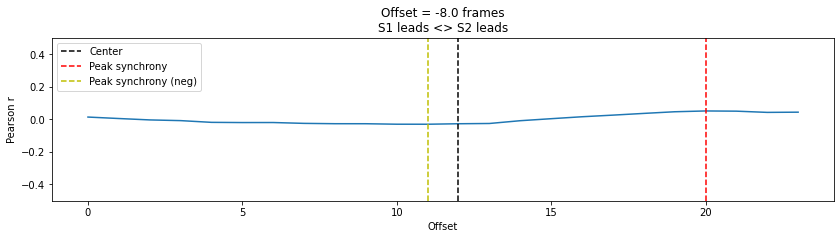

<matplotlib.legend.Legend at 0x7f0518cd3a60>

In [ ]:
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.axvline(np.argmin(rs),color='y',linestyle='--',label='Peak synchrony (neg)')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.5,0.5], xlabel='Offset',ylabel='Pearson r')
# ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
# ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

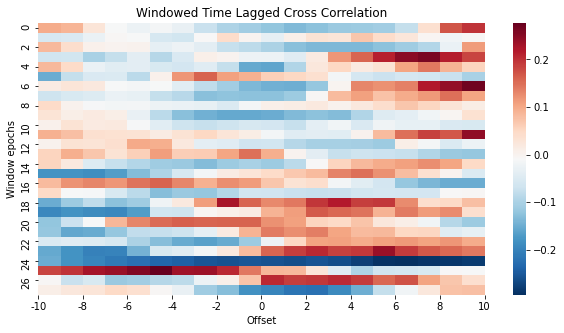

In [ ]:
no_splits = 28
samples_per_split = final_data.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = final_data['People Count_norm'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = final_data['prcp_norm'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-10,10)]
    rss.append(rs)
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,20], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]);

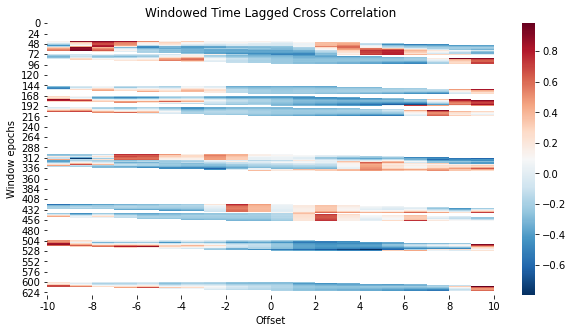

In [ ]:
window_size = 20
t_start = 0
t_end = t_start + window_size
step_size = 1
rss = []
while t_end < 650:
  d1 = final_data['People Count_norm'].iloc[t_start:t_end]
  d2 = final_data['prcp_norm'].iloc[t_start:t_end]
  rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-10,10)]
  rss.append(rs)
  t_start = t_start + step_size
  t_end = t_end + step_size
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,20], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]);

## Seats <-> BlipTrack

Gather overall seats by hour, selecting a couple time periods through the year. Run correlation for each checkpoint.

We can break this down along the lines created in the training data dataframes. (International/domestic, destinations, etc.)

### Gather Historical Flight Schedule

In [ ]:
query = "select * from predictive_model_tsa.{}_T{}_historical_fs_concourse".format('EWR', 'B')
flight_schedule = (spark.sql(query)).select('*')

curr_cols = flight_schedule.columns
new_cols = [x.replace("_", " ") for x in curr_cols]
flight_schedule = reduce(lambda flight_schedule, idx: flight_schedule.withColumnRenamed(curr_cols[idx], new_cols[idx]), range(len(curr_cols)), flight_schedule)

In [ ]:
display(flight_schedule)

Id,Flight Date,Flight Arrving Date Time,Flight Departing Date Time,Flight Date Time,Flight Arriving Time,Flight Departing Time,Date Hour Numeric,PA Time,Non-PA Time,Aircraft Id,Aircraft Code,Airline Id,ICAO Airline,Arriving from Airport Id,Departing to Airport Id,Dep Airport Code,Arr Airport Code,Context Airport Id,Non-Context Airport Id,State Id,Arr Terminal,Dep Terminal,Context Terminal,Flight Direction,Flight No,International Domestic,Mainline Low Cost,Service Type,Flight Type,Seats,Load Factor,Estimated Passenger,Flight Distance,Flight Duration,Valid Destination Indicator,Valid Carrier Indicator,Operating Airline Code,Operating Airline Name,TerminalId,Operating Airline Id,Flight Time,nonpaxratio,TSALoadFactor,Departure Concourse
98394474,2021-01-02,2021-01-02T11:25:00.000+0000,2021-01-02T11:15:00.000+0000,2021-01-02T11:15:00.000+0000,1900-01-01T11:25:00.000+0000,1900-01-01T11:15:00.000+0000,2021010211,1900-01-01T11:15:00.000+0000,1900-01-01T11:25:00.000+0000,6465,77L,404,AIC,100,116,EWR,DEL,116,100,-1,3,B,B,Departure,106,International,null,J,All Passenger Flights,238,0.74457649,177,7323,820,1,1,AI,Air India,10,404,1900-01-01T11:15:00.000+0000,null,null,Concourse B-3
98394693,2021-01-02,2021-01-02T19:10:00.000+0000,2021-01-02T15:10:00.000+0000,2021-01-02T15:10:00.000+0000,1900-01-01T19:10:00.000+0000,1900-01-01T15:10:00.000+0000,2021010215,1900-01-01T15:10:00.000+0000,1900-01-01T19:10:00.000+0000,6392,319,677,AVA,298,116,EWR,SAL,116,298,-1,,B,B,Departure,399,International,null,J,All Passenger Flights,120,0.83688220,100,2067,300,1,1,TA,Taca International Airlines,10,6105,1900-01-01T15:10:00.000+0000,null,null,Hard Stand
98394899,2021-01-01,2021-01-01T08:50:00.000+0000,2021-01-01T19:30:00.000+0000,2021-01-01T19:30:00.000+0000,1900-01-01T08:50:00.000+0000,1900-01-01T19:30:00.000+0000,2021010119,1900-01-01T19:30:00.000+0000,1900-01-01T08:50:00.000+0000,6395,321,6110,DJT,254,116,EWR,ORY,116,254,-1,4,B,B,Departure,101,International,null,J,All Passenger Flights,76,0.33662280,25,3648,440,1,1,B0,La Compagnie,10,6110,1900-01-01T19:30:00.000+0000,null,null,Concourse B-2
98394900,2021-01-02,2021-01-02T08:50:00.000+0000,2021-01-02T19:30:00.000+0000,2021-01-02T19:30:00.000+0000,1900-01-01T08:50:00.000+0000,1900-01-01T19:30:00.000+0000,2021010219,1900-01-01T19:30:00.000+0000,1900-01-01T08:50:00.000+0000,6395,321,6110,DJT,254,116,EWR,ORY,116,254,-1,4,B,B,Departure,101,International,null,J,All Passenger Flights,76,0.33662280,25,3648,440,1,1,B0,La Compagnie,10,6110,1900-01-01T19:30:00.000+0000,null,null,Concourse B-2
98394985,2021-01-01,2021-01-01T11:00:00.000+0000,2021-01-01T21:50:00.000+0000,2021-01-01T21:50:00.000+0000,1900-01-01T11:00:00.000+0000,1900-01-01T21:50:00.000+0000,2021010121,1900-01-01T21:50:00.000+0000,1900-01-01T11:00:00.000+0000,6395,321,6110,DJT,254,116,EWR,ORY,116,254,-1,4,B,B,Departure,103,International,null,J,All Passenger Flights,76,0.33662280,25,3648,430,1,1,B0,La Compagnie,10,6110,1900-01-01T21:50:00.000+0000,null,null,Concourse B-3
98394986,2021-01-02,2021-01-02T11:00:00.000+0000,2021-01-02T21:50:00.000+0000,2021-01-02T21:50:00.000+0000,1900-01-01T11:00:00.000+0000,1900-01-01T21:50:00.000+0000,2021010221,1900-01-01T21:50:00.000+0000,1900-01-01T11:00:00.000+0000,6395,321,6110,DJT,254,116,EWR,ORY,116,254,-1,4,B,B,Departure,103,International,null,J,All Passenger Flights,76,0.33662280,25,3648,430,1,1,B0,La Compagnie,10,6110,1900-01-01T21:50:00.000+0000,null,null,Concourse B-3
98395623,2021-01-01,2021-01-01T12:20:00.000+0000,2021-01-01T11:45:00.000+0000,2021-01-01T11:45:00.000+0000,1900-01-01T12:20:00.000+0000,1900-01-01T11:45:00.000+0000,2021010111,1900-01-01T11:45:00.000+0000,1900-01-01T12:20:00.000+0000,6470,788,404,AIC,54,116,EWR,BOM,116,54,-1,2,B,B,Departure,144,International,null,J,All Passenger Flights,256,0.74457649,190,7806,845,1,1,AI,Air India,10,404,1900-01-01T11:45:00.000+0000,null,null,Concourse B-3
98396395,2021-01-01,2021-01-01T13:05:00.000+0000,2021-01-01T23:55:00.000+0000,2021-01-01T23:55:00.000+0000,190

In [ ]:
#filter for B-1
fs_concourse = "Concourse {}".format(concourse)
flight_schedule_filtered = flight_schedule.filter(flight_schedule['Departure Concourse'].isin([fs_concourse, 'Unknown'])) \
                                .filter(flight_schedule['Flight Date'] >= begin_date) \
                                .filter(flight_schedule['Flight Date'] < end_date)

In [ ]:
display(flight_schedule_filtered)

Id,Flight Date,Flight Arrving Date Time,Flight Departing Date Time,Flight Date Time,Flight Arriving Time,Flight Departing Time,Date Hour Numeric,PA Time,Non-PA Time,Aircraft Id,Aircraft Code,Airline Id,ICAO Airline,Arriving from Airport Id,Departing to Airport Id,Dep Airport Code,Arr Airport Code,Context Airport Id,Non-Context Airport Id,State Id,Arr Terminal,Dep Terminal,Context Terminal,Flight Direction,Flight No,International Domestic,Mainline Low Cost,Service Type,Flight Type,Seats,Load Factor,Estimated Passenger,Flight Distance,Flight Duration,Valid Destination Indicator,Valid Carrier Indicator,Operating Airline Code,Operating Airline Name,TerminalId,Operating Airline Id,Flight Time,nonpaxratio,TSALoadFactor,Departure Concourse
210102100,2021-06-01,2021-06-01T13:12:00.000+0000,2021-06-01T11:22:00.000+0000,2021-06-01T11:22:00.000+0000,1900-01-01T13:12:00.000+0000,1900-01-01T11:22:00.000+0000,2021060111,1900-01-01T11:22:00.000+0000,1900-01-01T13:12:00.000+0000,6614,CR9,1486,DAL,107,116,EWR,DTW,116,107,23,EM,B,B,Departure,5187,Domestic,null,J,All Passenger Flights,76,0.48261987,36,488,110,1,1,9E,Endeavor Air,10,6109,1900-01-01T11:22:00.000+0000,null,null,Concourse B-1
210102246,2021-06-01,2021-06-01T21:35:00.000+0000,2021-06-01T18:15:00.000+0000,2021-06-01T18:15:00.000+0000,1900-01-01T21:35:00.000+0000,1900-01-01T18:15:00.000+0000,2021060118,1900-01-01T18:15:00.000+0000,1900-01-01T21:35:00.000+0000,6425,739,1486,DAL,318,116,EWR,SLC,116,318,45,,B,B,Departure,474,Domestic,null,J,All Passenger Flights,180,0.52705428,94,1969,320,1,1,DL,Delta Air Lines,10,1486,1900-01-01T18:15:00.000+0000,null,null,Concourse B-1
210102528,2021-06-01,2021-06-01T12:24:00.000+0000,2021-06-01T10:00:00.000+0000,2021-06-01T10:00:00.000+0000,1900-01-01T12:24:00.000+0000,1900-01-01T10:00:00.000+0000,2021060110,1900-01-01T10:00:00.000+0000,1900-01-01T12:24:00.000+0000,6425,739,1486,DAL,25,116,EWR,ATL,116,25,11,S,B,B,Departure,725,Domestic,null,J,All Passenger Flights,180,0.52705428,94,746,144,1,1,DL,Delta Air Lines,10,1486,1900-01-01T10:00:00.000+0000,null,null,Concourse B-1
210102533,2021-06-01,2021-06-01T16:01:00.000+0000,2021-06-01T13:50:00.000+0000,2021-06-01T13:50:00.000+0000,1900-01-01T16:01:00.000+0000,1900-01-01T13:50:00.000+0000,2021060113,1900-01-01T13:50:00.000+0000,1900-01-01T16:01:00.000+0000,6424,738,1486,DAL,25,116,EWR,ATL,116,25,11,S,B,B,Departure,1297,Domestic,null,J,All Passenger Flights,160,0.52705428,84,746,131,1,1,DL,Delta Air Lines,10,1486,1900-01-01T13:50:00.000+0000,null,null,Concourse B-1
210103238,2021-06-01,2021-06-01T13:01:00.000+0000,2021-06-01T11:00:00.000+0000,2021-06-01T11:00:00.000+0000,1900-01-01T13:01:00.000+0000,1900-01-01T11:00:00.000+0000,2021060111,1900-01-01T11:00:00.000+0000,1900-01-01T13:01:00.000+0000,6613,CR7,1486,DAL,94,116,EWR,CVG,116,94,18,,B,B,Departure,4987,Domestic,null,J,All Passenger Flights,69,0.48261987,33,569,121,1,1,9E,Endeavor Air,10,6109,1900-01-01T11:00:00.000+0000,null,null,Concourse B-1
210106375,2021-06-01,2021-06-01T17:21:00.000+0000,2021-06-01T15:05:00.000+0000,2021-06-01T15:05:00.000+0000,1900-01-01T17:21:00.000+0000,1900-01-01T15:05:00.000+0000,2021060115,1900-01-01T15:05:00.000+0000,1900-01-01T17:21:00.000+0000,6425,739,1486,DAL,25,116,EWR,ATL,116,25,11,S,B,B,Departure,2144,Domestic,null,J,All Passenger Flights,180,0.52705428,94,746,136,1,1,DL,Delta Air Lines,10,1486,1900-01-01T15:05:00.000+0000,null,null,Concourse B-1
210106470,2021-06-01,2021-06-01T09:28:00.000+0000,2021-06-01T07:30:00.000+0000,2021-06-01T07:30:00.000+0000,1900-01-01T09:28:00.000+0000,1900-01-01T07:30:00.000+0000,2021060107,1900-01-01T07:30:00.000+0000,1900-01-01T09:28:00.000+0000,6425,739,1486,DAL,228,116,EWR,MSP,116,228,24,1,B,B,Departure,2250,Domestic,null,J,All Passenger Flights,180,0.52705428,94,1008,178,1,1,DL,Delta Air Lines,10,1486,1900-01-01T07:30:00.000+0000,null,null,Concourse B-1
210106786,2021-06-01,2021-06-01T15:00:00.000+0000,2021-06-01T13:00:00.000+0000,2021-06-01T13:00:00.000+0000,1900-01-01T15:00:00.000

In [ ]:
domestic_seats = flight_schedule_filtered.filter(flight_schedule_filtered['International Domestic'] == 'Domestic') \
                                .select(["Flight Date", "Flight Date Time", "Seats"])
  
domestic_seats = domestic_seats.withColumn("Domestic Seats", domestic_seats['Seats'].cast(DoubleType()))
domestic_seats = domestic_seats.withColumn("Hour", hour(col('Flight Date Time')))

domestic_seats_daily = domestic_seats.groupBy('Flight Date').sum('Domestic Seats').select(col('sum(Domestic Seats)').alias('Domestic_Daily_Seats'), col('Flight Date').alias('Date'))
domestic_seats_hourly = domestic_seats.groupBy(['Flight Date', 'Hour']).sum('Domestic Seats').select(col('sum(Domestic Seats)').alias('Domestic_Hourly_Seats'), col('Flight Date').alias('Date'), col('Hour').alias('Hour'))

In [ ]:
international_seats = flight_schedule_filtered.filter(flight_schedule_filtered['International Domestic'] == 'International') \
                                .select(["Flight Date", "Flight Date Time", "Seats"])
  
international_seats = international_seats.withColumn("International Seats", domestic_seats['Seats'].cast(DoubleType()))
international_seats = international_seats.withColumn("Hour", hour(col('Flight Date Time')))

international_seats_daily = international_seats.groupBy('Flight Date').sum('International Seats').select(col('sum(International Seats)').alias('International_Daily_Seats'), col('Flight Date').alias('Date'))
international_seats_hourly = international_seats.groupBy(['Flight Date', 'Hour']).sum('International Seats').select(col('sum(International Seats)').alias('International_Hourly_Seats'), col('Flight Date').alias('Date'), col('Hour').alias('Hour'))

### Merge Data

In [ ]:
bt_domestic = domestic_seats_hourly.join(bliptrack_counts, on = ['Date', 'Hour'], how = 'right')
bt_domestic = bt_domestic.fillna(0)

bt_domestic = international_seats_hourly.join(bt_domestic, on = ['Date', 'Hour'], how = 'right')
bt_domestic = bt_domestic.fillna(0)


bt_domestic = bt_domestic.toPandas()

In [ ]:
#normalize
bt_domestic[['Domestic_Hourly_Seats', 'People Count', 'International_Hourly_Seats']]=(bt_domestic[['Domestic_Hourly_Seats', 'People Count', 'International_Hourly_Seats']]-bt_domestic[['Domestic_Hourly_Seats', 'People Count', 'International_Hourly_Seats']].min())/(bt_domestic[['Domestic_Hourly_Seats', 'People Count', 'International_Hourly_Seats']].max()-bt_domestic[['Domestic_Hourly_Seats', 'People Count', 'International_Hourly_Seats']].min())

In [ ]:
bt_domestic

Out[77]:

,Date,Hour,International_Hourly_Seats,Domestic_Hourly_Seats,People Count
0,2021-08-03,14,0.000000,0.215852,0.219570
1,2021-09-13,18,0.000000,0.694772,0.162291
2,2022-02-25,6,0.000000,0.243676,0.429594
3,2021-10-23,14,0.000000,0.455312,0.206444
4,2021-07-26,6,0.808696,0.723440,0.867542
...,...,...,...,...,...
6097,2021-11-22,3,0.000000,0.000000,0.041766
6098,2021-10-02,22,0.000000,0.000000,0.002387
6099,2021-07-09,1,0.000000,0.000000,0.007160
6100,2021-06-27,21,0.000000,0.000000,0.002387


### Correlations

#### Domestic

In [ ]:
data_2 = bt_domestic['Domestic_Hourly_Seats']
data_1 = bt_domestic['People Count']

In [ ]:
corr_value = crosscorr(data_1, data_2)
corr_value

Out[79]: 0.3920893286912646

In [ ]:
rs = [crosscorr(data_1, data_2, lag) for lag in range(-10,10)]

Out[81]:

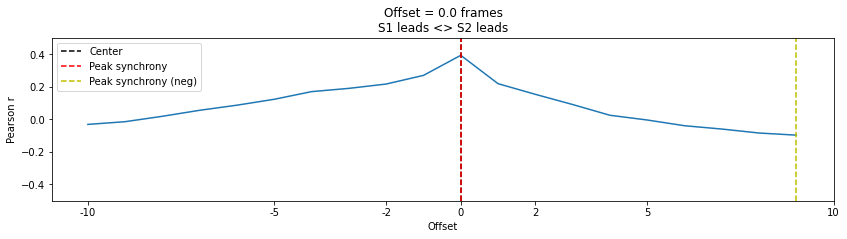

<matplotlib.legend.Legend at 0x7f0518587fa0>

In [ ]:
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.axvline(np.argmin(rs),color='y',linestyle='--',label='Peak synchrony (neg)')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.5,0.5], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 5, 8, 10, 12, 15, 20])
ax.set_xticklabels([-10, -5, -2, 0, 2, 5, 10]);
plt.legend()

RuntimeWarning: Degrees of freedom <= 0 for slice
RuntimeWarning: divide by zero encountered in true_divide

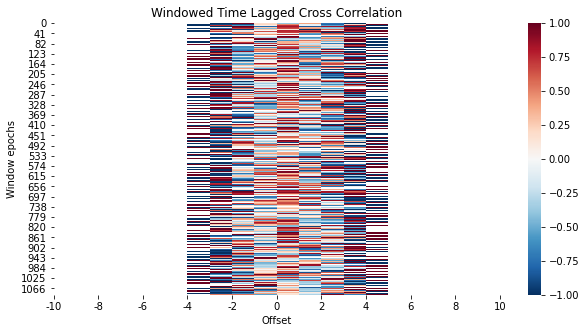

In [ ]:
no_splits = 273
samples_per_split = bt_domestic.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = bt_domestic['People Count'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = bt_domestic['Domestic_Hourly_Seats'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-10,10)]
    rss.append(rs)
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,20], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]);

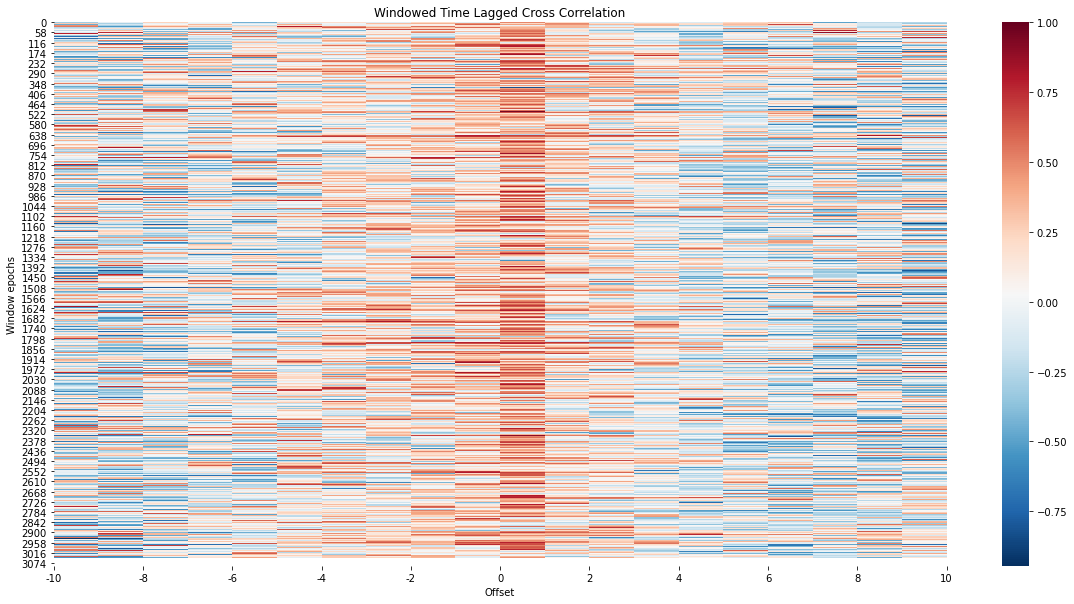

In [ ]:
window_size = 20
t_start = 0
t_end = t_start + window_size
step_size = 2
rss = []
while t_end < 6200:
  d1 = bt_domestic['People Count'].iloc[t_start:t_end]
  d2 = bt_domestic['Domestic_Hourly_Seats'].iloc[t_start:t_end]
  rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-10,10)]
  rss.append(rs)
  t_start = t_start + step_size
  t_end = t_end + step_size
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(20,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,20], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]);

#### International

In [ ]:
data_2 = bt_domestic['International_Hourly_Seats']
data_1 = bt_domestic['People Count']

Out[85]:

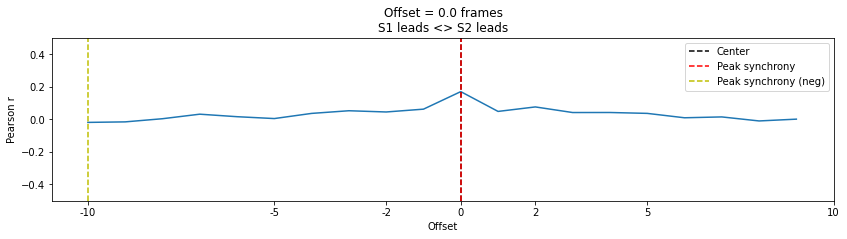

<matplotlib.legend.Legend at 0x7f0518d54a30>

In [ ]:
rs = [crosscorr(data_1, data_2, lag) for lag in range(-10,10)]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.axvline(np.argmin(rs),color='y',linestyle='--',label='Peak synchrony (neg)')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.5,0.5], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 5, 8, 10, 12, 15, 20])
ax.set_xticklabels([-10, -5, -2, 0, 2, 5, 10]);
plt.legend()

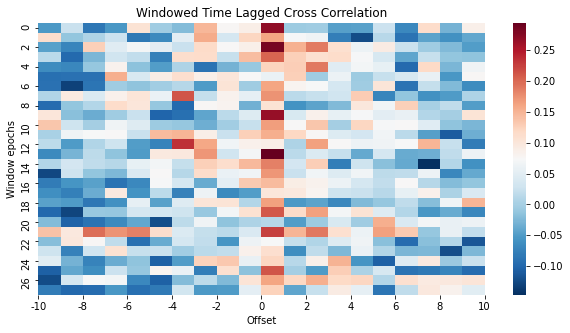

In [ ]:
no_splits = 28
samples_per_split = bt_domestic.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = bt_domestic['People Count'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = bt_domestic['International_Hourly_Seats'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-10,10)]
    rss.append(rs)
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,20], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]);

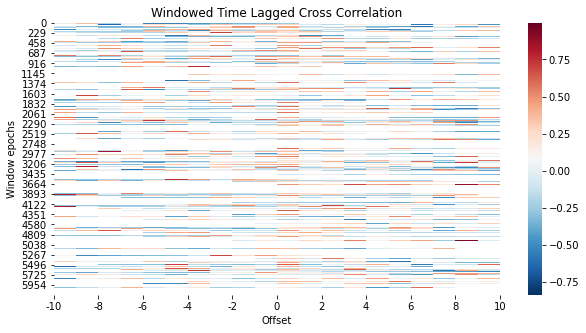

In [ ]:
window_size = 20
t_start = 0
t_end = t_start + window_size
step_size = 1
rss = []
while t_end < 6200:
  d1 = bt_domestic['People Count'].iloc[t_start:t_end]
  d2 = bt_domestic['International_Hourly_Seats'].iloc[t_start:t_end]
  rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-10,10)]
  rss.append(rs)
  t_start = t_start + step_size
  t_end = t_end + step_size
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,20], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax.set_xticklabels([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]);